In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/seoul-bike-trip-duration-prediction/For_modeling.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.metrics.pairwise import haversine_distances
from math import radians, cos, sin, asin, sqrt

from sklearn.model_selection import train_test_split

from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor


from sklearn.metrics import classification_report, mean_absolute_error, mean_squared_error, r2_score

In [3]:
#to see maximum columns
pd.set_option("display.max_columns", None)

seoul_data = pd.read_csv("../input/seoul-bike-trip-duration-prediction/For_modeling.csv", index_col=[0])

#to get the gist of the data
seoul_data.head()

/opt/conda/lib/python3.7/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Duration  Distance      PLong       PLatd      DLong       DLatd  \
0         3        50  37.544666  126.888359  37.544666  126.888359   
1        24      7670  37.506199  127.003944  37.551250  127.035103   
2         8      1390  37.544590  127.057083  37.537014  127.061096   
3         8      1820  37.571102  127.023560  37.561447  127.034920   
4         4       850  37.573242  127.015907  37.565849  127.016403   

   Haversine  Pmonth  Pday  Phour  Pmin  PDweek  Dmonth  Dday  Dhour  Dmin  \
0   0.000000       1     1      0     0       0       1     1      0     4   
1   5.713529       1     1      0     0       0       1     1      0    25   
2   0.913702       1     1      0     0       0       1     1      0     9   
3   1.468027       1     1      0     1       0       1     1      0    10   
4   0.823227       1     1      0     1       0       1     1      0     6   

   DDweek  Temp  Precip  Wind  Humid  Solar  Snow  GroundTemp  Dust  
0       0  -3.2     0.0   0.5   40.0    0.0   0.0        -2.2  25.0  
1       0  -3.2     0.0   0.5   40.0    0.0   0.0        -2.2  25.0  
2       0  -3.2     0.0   0.5   40.0    0.0   0.0        -2.2  25.0  
3       0  -3.2     0.0   0.5   40.0    0.0   0.0        -2.2  25.0  
4       0  -3.2     0.0   0.5   40.0    0.0   0.0        -2.2  25.0

In [4]:
seoul_data.shape


(9601139, 25)

In [5]:
seoul_data.isna().sum()

Duration      0
Distance      0
PLong         0
PLatd         0
DLong         0
DLatd         0
Haversine     0
Pmonth        0
Pday          0
Phour         0
Pmin          0
PDweek        0
Dmonth        0
Dday          0
Dhour         0
Dmin          0
DDweek        0
Temp          0
Precip        0
Wind          0
Humid         0
Solar         0
Snow          0
GroundTemp    0
Dust          0
dtype: int64

In [6]:
seoul_data.describe()

Duration      Distance         PLong         PLatd         DLong  \
count  9.601139e+06  9.601139e+06  9.601139e+06  9.601139e+06  9.601139e+06   
mean   2.580294e+01  3.713519e+03  3.754761e+01  1.269908e+02  3.754770e+01   
std    2.504333e+01  3.956611e+03  4.441376e-02  8.257065e-02  4.445305e-02   
min    1.000000e+00  1.000000e+00  3.743727e+01  1.267986e+02  3.743727e+01   
25%    8.000000e+00  1.230000e+03  3.751424e+01  1.269200e+02  3.751424e+01   
50%    1.600000e+01  2.280000e+03  3.754693e+01  1.269943e+02  3.754655e+01   
75%    3.600000e+01  4.620000e+03  3.757324e+01  1.270618e+02  3.757324e+01   
max    1.190000e+02  3.329000e+04  3.768972e+01  1.271803e+02  3.768972e+01   

              DLatd     Haversine        Pmonth          Pday         Phour  \
count  9.601139e+06  9.601139e+06  9.601139e+06  9.601139e+06  9.601139e+06   
mean   1.269907e+02  1.870315e+00  7.578754e+00  1.576714e+01  1.437801e+01   
std    8.323726e-02  1.995361e+00  2.696797e+00  8.748012e+00  6.249244e+00   
min    1.267986e+02  0.000000e+00  1.000000e+00  1.000000e+00  0.000000e+00   
25%    1.269194e+02  6.758669e-01  6.000000e+00  8.000000e+00  1.000000e+01   
50%    1.269947e+02  1.257498e+00  8.000000e+00  1.600000e+01  1.600000e+01   
75%    1.270624e+02  2.363812e+00  1.000000e+01  2.300000e+01  1.900000e+01   
max    1.271803e+02  2.863448e+01  1.200000e+01  3.100000e+01  2.300000e+01   

               Pmin        PDweek        Dmonth          Dday         Dhour  \
count  9.601139e+06  9.601139e+06  9.601139e+06  9.601139e+06  9.601139e+06   
mean   2.914948e+01  2.943812e+00  7.579198e+00  1.576666e+01  1.442620e+01   
std    1.725837e+01  1.976063e+00  2.696781e+00  8.747788e+00  6.484493e+00   
min    0.000000e+00  0.000000e+00  1.000000e+00  1.000000e+00  0.000000e+00   
25%    1.400000e+01  1.000000e+00  6.000000e+00  8.000000e+00  1.000000e+01   
50%    2.900000e+01  3.000000e+00  8.000000e+00  1.600000e+01  1.600000e+01   
75%    4.400000e+01  5.000000e+00  1.000000e+01  2.300000e+01  2.000000e+01   
max    5.900000e+01  6.000000e+00  1.200000e+01  3.100000e+01  2.300000e+01   

               Dmin        DDweek          Temp        Precip          Wind  \
count  9.601139e+06  9.601139e+06  9.601139e+06  9.601139e+06  9.601139e+06   
mean   2.999278e+01  2.945771e+00  1.856201e+01  1.784856e-02  1.819274e+00   
std    1.730960e+01  1.977624e+00  9.498075e+00  3.736282e-01  9.710258e-01   
min    0.000000e+00  0.000000e+00 -1.780000e+01  0.000000e+00  0.000000e+00   
25%    1.500000e+01  1.000000e+00  1.220000e+01  0.000000e+00  1.100000e+00   
50%    3.000000e+01  3.000000e+00  2.010000e+01  0.000000e+00  1.700000e+00   
75%    4.500000e+01  5.000000e+00  2.550000e+01  0.000000e+00  2.400000e+00   
max    5.900000e+01  6.000000e+00  3.940000e+01  3.500000e+01  7.400000e+00   

              Humid         Solar          Snow    GroundTemp          Dust  
count  9.601139e+06  9.601139e+06  9.601139e+06  9.601139e+06  9.601139e+06  
mean   5.397565e+01  7.300679e-01  9.948924e-03  2.072376e+01  3.245798e+01  
std    1.742159e+01  9.175004e-01  1.628091e-01  1.265221e+01  2.407264e+01  
min    1.000000e+01  0.000000e+00  0.000000e+00 -1.360000e+01  0.000000e+00  
25%    4.100000e+01  0.000000e+00  0.000000e+00  1.160000e+01  1.600000e+01  
50%    5.300000e+01  2.700000e-01  0.000000e+00  2.110000e+01  2.700000e+01  
75%    6.700000e+01  1.260000e+00  0.000000e+00  2.850000e+01  4.200000e+01  
max    9.800000e+01  3.520000e+00  8.800000e+00  6.220000e+01  3.040000e+02

In [7]:
seoul_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9601139 entries, 0 to 9830310
Data columns (total 25 columns):
 #   Column      Dtype  
---  ------      -----  
 0   Duration    int64  
 1   Distance    int64  
 2   PLong       float64
 3   PLatd       float64
 4   DLong       float64
 5   DLatd       float64
 6   Haversine   float64
 7   Pmonth      int64  
 8   Pday        int64  
 9   Phour       int64  
 10  Pmin        int64  
 11  PDweek      int64  
 12  Dmonth      int64  
 13  Dday        int64  
 14  Dhour       int64  
 15  Dmin        int64  
 16  DDweek      int64  
 17  Temp        float64
 18  Precip      float64
 19  Wind        float64
 20  Humid       float64
 21  Solar       float64
 22  Snow        float64
 23  GroundTemp  float64
 24  Dust        float64
dtypes: float64(13), int64(12)
memory usage: 1.9 GB


In [8]:
seoul_data.nunique()

Duration         119
Distance        3385
PLong           1497
PLatd           1504
DLong           1501
DLatd           1508
Haversine     238583
Pmonth            12
Pday              31
Phour             24
Pmin              60
PDweek             7
Dmonth            12
Dday              31
Dhour             24
Dmin              60
DDweek             7
Temp             547
Precip            60
Wind              65
Humid             89
Solar            345
Snow              42
GroundTemp       700
Dust             163
dtype: int64

In [9]:
seoul_data.Duration.value_counts()

5      434870
6      431674
4      415106
7      410592
8      389080
        ...  
115     10900
116     10352
117      9851
118      8817
119      7685
Name: Duration, Length: 119, dtype: int64

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[Text(0.5, 0, '')]

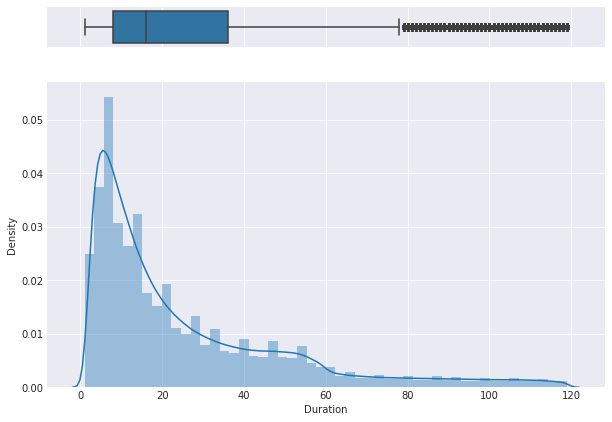

In [10]:
# Cut the window in 2 parts
plt.style.use('seaborn-darkgrid')
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.10, .75)}, figsize=(10,7))

# Add a graph in each part
sns.boxplot(seoul_data["Duration"], ax=ax_box)
sns.distplot(seoul_data["Duration"], ax=ax_hist)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')

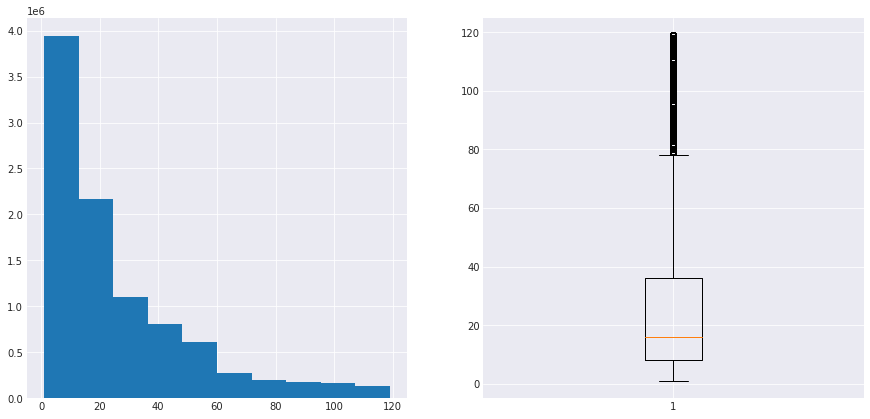

In [11]:
figs = plt.figure(figsize=(15,7))
ax1 = figs.add_subplot(121)
ax2 = figs.add_subplot(122)
x = seoul_data["Duration"]
ax1.hist(x)
ax2.boxplot(x);

In [12]:
seoul_data.Haversine.value_counts()

0.000000     955083
0.936970      13652
0.452993      10990
0.612179       8593
0.714991       8228
              ...  
8.850571          1
8.520064          1
10.239679         1
10.929690         1
8.779307          1
Name: Haversine, Length: 238583, dtype: int64

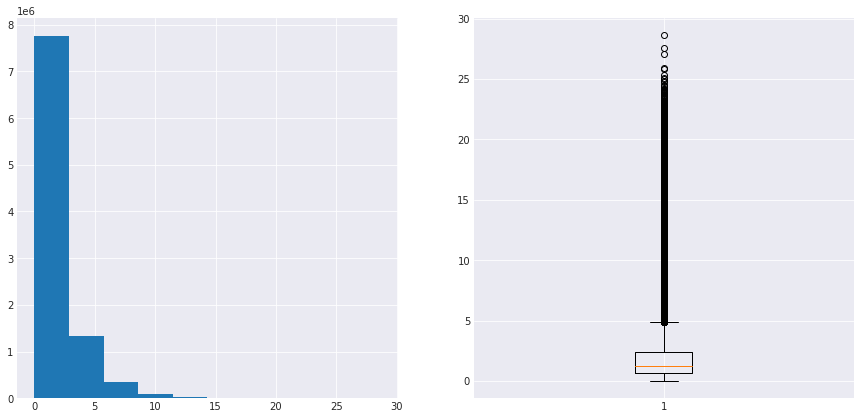

In [13]:
figs = plt.figure(figsize=(15,7))
ax1 = figs.add_subplot(121)
ax2 = figs.add_subplot(122)
x = seoul_data["Haversine"]
ax1.hist(x)
ax2.boxplot(x);

In [14]:
seoul_data.Distance.value_counts()

910     34587
900     33774
1100    33565
950     33549
930     33486
        ...  
47          1
7738        1
617         1
28          1
23          1
Name: Distance, Length: 3385, dtype: int64

{'whiskers': [<matplotlib.lines.Line2D at 0x7f4de7553890>,
 'caps': [<matplotlib.lines.Line2D at 0x7f4de755d150>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f4de7553510>],
 'medians': [<matplotlib.lines.Line2D at 0x7f4de755da10>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f4de755de10>],
 'means': []}

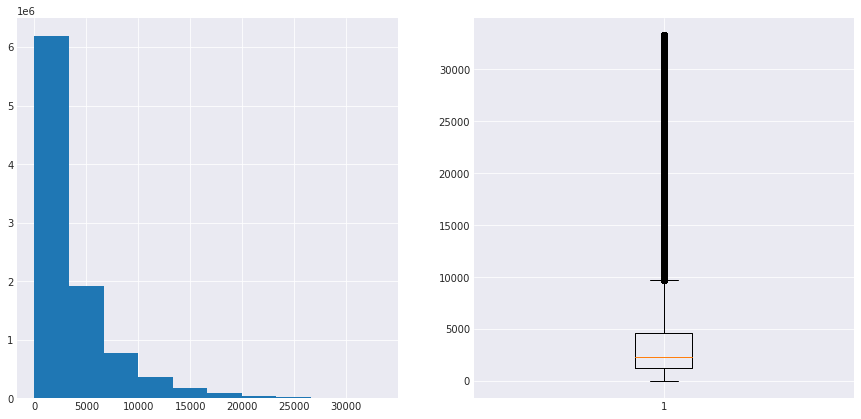

In [15]:
figs = plt.figure(figsize=(15,7))
ax1 = figs.add_subplot(121)
ax2 = figs.add_subplot(122)
x = seoul_data["Distance"]
ax1.hist(x)
ax2.boxplot(x)

In [16]:
seoul_data.Temp.value_counts()

 23.4    64964
 24.2    63581
 25.0    58512
 21.2    56605
 19.0    55647
         ...  
-14.5       81
-17.4       62
-15.4       49
-11.9       44
-16.9       34
Name: Temp, Length: 547, dtype: int64

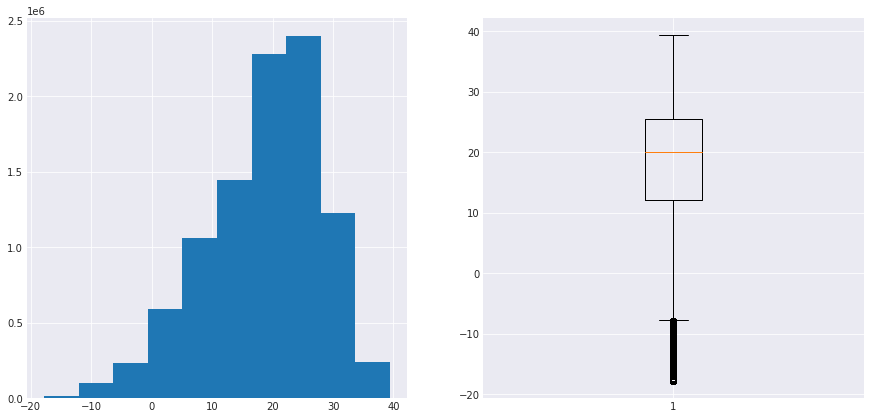

In [17]:
figs = plt.figure(figsize=(15,7))
ax1 = figs.add_subplot(121)
ax2 = figs.add_subplot(122)
x = seoul_data["Temp"]
ax1.hist(x)
ax2.boxplot(x);

In [18]:
seoul_data.Precip.value_counts()

0.0     9485238
0.5       38451
0.1       22246
1.0       10774
1.5        8483
2.0        4916
4.0        4609
0.2        4156
0.4        2723
0.9        2514
3.5        2277
0.3        1935
2.5        1364
1.3        1273
6.4        1014
1.1         958
21.5        694
3.0         682
5.0         662
4.5         654
7.3         573
5.5         449
6.5         406
1.6         377
0.8         329
1.8         274
18.0        273
13.5        249
11.5        194
3.3         181
8.0         180
13.0        176
5.4         170
29.5        152
35.0        147
7.0         145
9.5         144
18.5        130
6.0         107
9.0         105
1.4          99
10.5         72
4.9          70
24.0         65
1.2          57
19.0         52
8.5          45
9.1          39
2.4          36
3.7          34
17.0         31
10.0         29
1.9          23
21.0         20
14.5         19
12.5         17
15.5         15
12.0         12
7.5          10
16.0         10
Name: Precip, dtype: int64

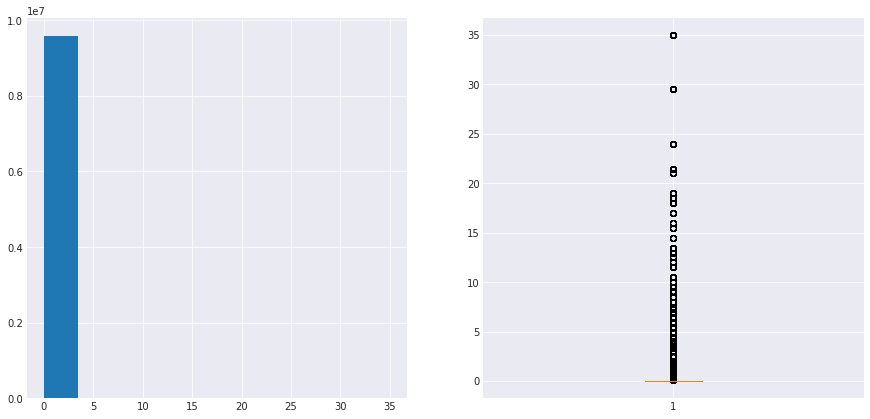

In [19]:
figs = plt.figure(figsize=(15,7))
ax1 = figs.add_subplot(121)
ax2 = figs.add_subplot(122)
x = seoul_data["Precip"]
ax1.hist(x)
ax2.boxplot(x);

In [20]:
seoul_data.Wind.value_counts()

1.4    484030
1.2    466608
1.5    433789
1.1    432783
1.7    385670
        ...  
6.0       566
6.1       351
6.7       146
7.3       138
6.9        67
Name: Wind, Length: 65, dtype: int64

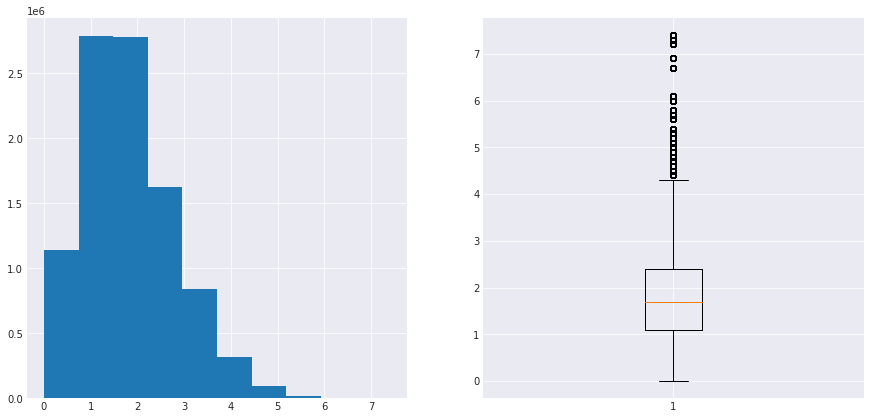

In [21]:
figs = plt.figure(figsize=(15,7))
ax1 = figs.add_subplot(121)
ax2 = figs.add_subplot(122)
x = seoul_data["Wind"]
ax1.hist(x)
ax2.boxplot(x);

In [22]:
seoul_data.GroundTemp.value_counts()

 0.0     53281
 18.0    52730
 24.1    51955
 19.6    50644
 27.6    47191
         ...  
-13.2       62
-12.8       58
-12.1       53
-11.9       44
-13.0       34
Name: GroundTemp, Length: 700, dtype: int64

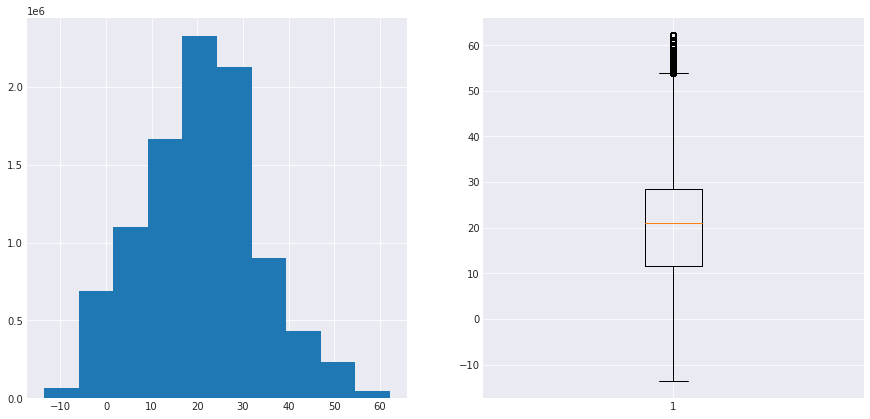

In [23]:
figs = plt.figure(figsize=(15,7))
ax1 = figs.add_subplot(121)
ax2 = figs.add_subplot(122)
x = seoul_data["GroundTemp"]
ax1.hist(x)
ax2.boxplot(x);

In [24]:
seoul_data.Solar.value_counts()

0.00    3439939
0.01     166151
0.02     103065
0.03      99673
0.06      94949
         ...   
2.69       1454
3.38       1423
3.44       1389
2.97       1329
3.45        898
Name: Solar, Length: 345, dtype: int64

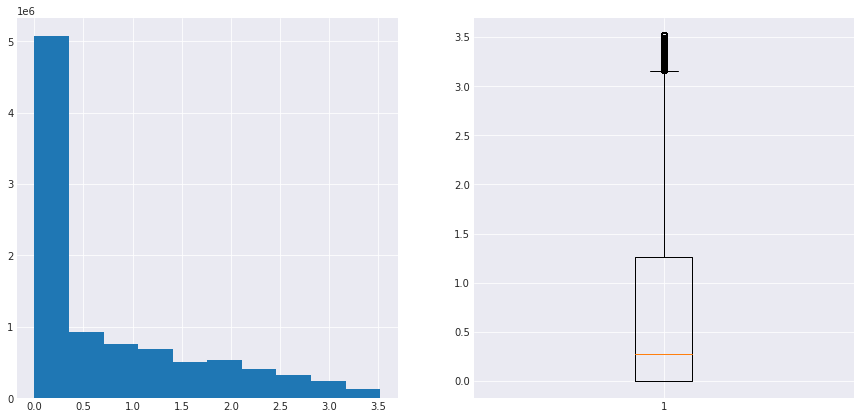

In [25]:
figs = plt.figure(figsize=(15,7))
ax1 = figs.add_subplot(121)
ax2 = figs.add_subplot(122)
x = seoul_data["Solar"]
ax1.hist(x)
ax2.boxplot(x);

In [26]:
seoul_data.Snow.value_counts()

0.0    9531693
0.3       9715
0.4       8624
1.0       4779
0.5       4529
0.7       3791
0.9       3278
1.6       3199
0.2       2535
3.5       2432
0.8       2232
0.6       2130
3.0       1798
1.3       1758
1.8       1685
2.5       1527
3.2       1451
1.1       1447
3.3       1341
2.2       1324
2.9       1189
0.1        912
3.7        831
2.3        805
3.6        676
2.4        661
4.1        632
2.8        522
5.0        471
1.7        451
1.5        437
6.0        385
3.4        372
8.8        280
3.8        277
7.0        274
2.6        218
1.4        199
4.0        105
2.0         99
7.1         39
3.9         36
Name: Snow, dtype: int64

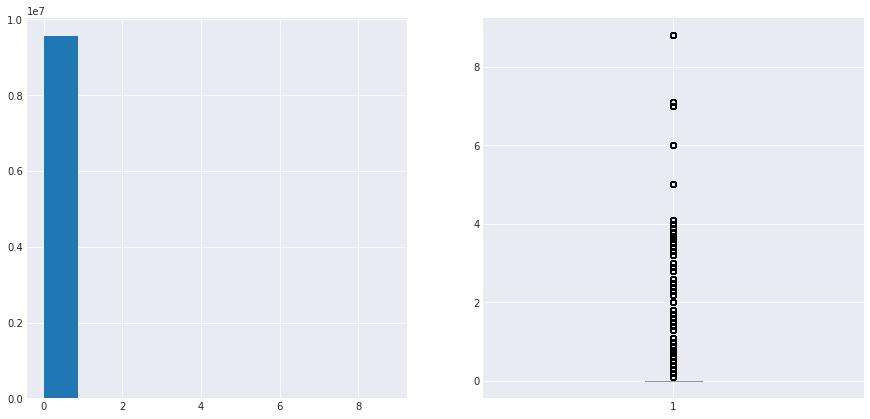

In [27]:
figs = plt.figure(figsize=(15,7))
ax1 = figs.add_subplot(121)
ax2 = figs.add_subplot(122)
x = seoul_data["Snow"]
ax1.hist(x)
ax2.boxplot(x);

In [28]:
seoul_data.Humid.value_counts()

53.0    226480
43.0    226107
56.0    218673
47.0    215315
52.0    210811
         ...  
13.0      6012
92.0      4033
11.0      2802
12.0      2779
10.0      1569
Name: Humid, Length: 89, dtype: int64

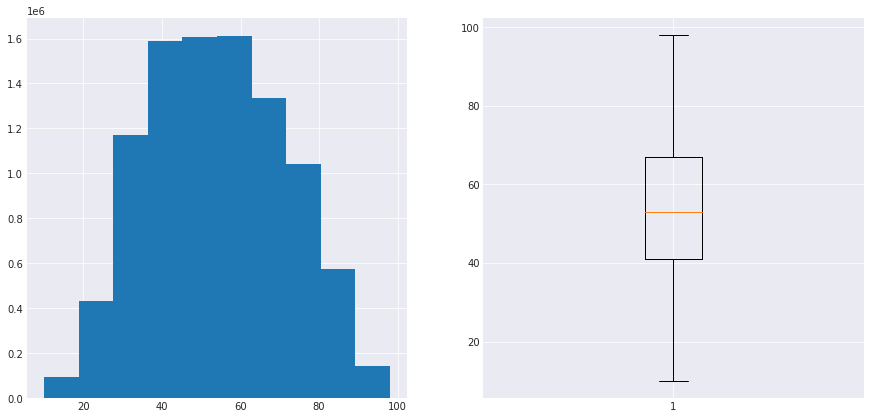

In [29]:
figs = plt.figure(figsize=(15,7))
ax1 = figs.add_subplot(121)
ax2 = figs.add_subplot(122)
x = seoul_data["Humid"]
ax1.hist(x)
ax2.boxplot(x);

In [30]:
seoul_data.Dust.value_counts()

22.0     273265
23.0     251987
13.0     250750
28.0     239957
0.0      237024
          ...  
116.0       278
169.0       234
125.0       202
139.0       129
155.0        59
Name: Dust, Length: 163, dtype: int64

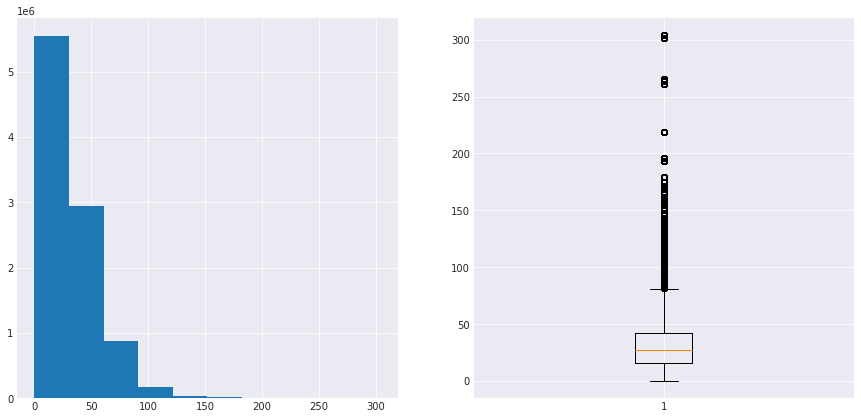

In [31]:
figs = plt.figure(figsize=(15,7))
ax1 = figs.add_subplot(121)
ax2 = figs.add_subplot(122)
x = seoul_data["Dust"]
ax1.hist(x)
ax2.boxplot(x);

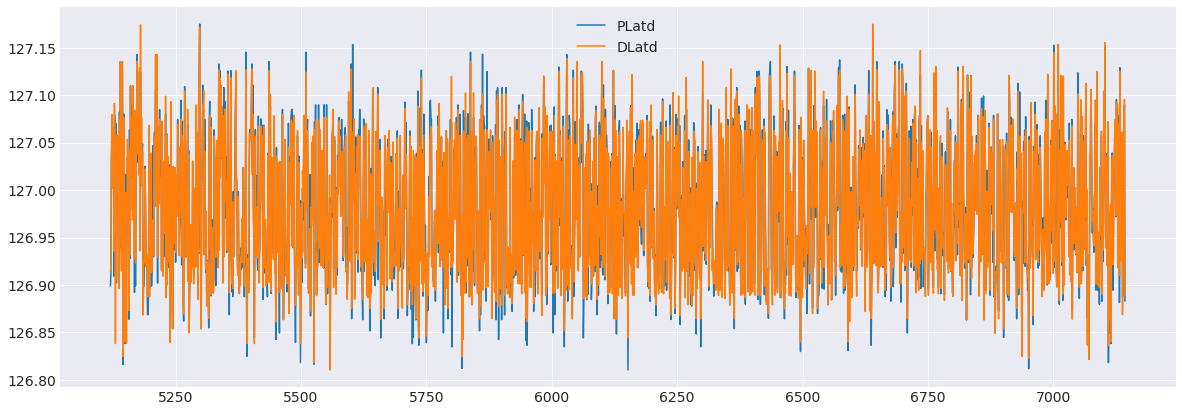

In [32]:
plt.figure(figsize = (20,7))
plt.rc('font', size=14)
plt.plot(seoul_data['PLatd'][5000:7000], label = "PLatd")
plt.plot(seoul_data['DLatd'][5000:7000], label = "DLatd")
plt.legend()
plt.show()

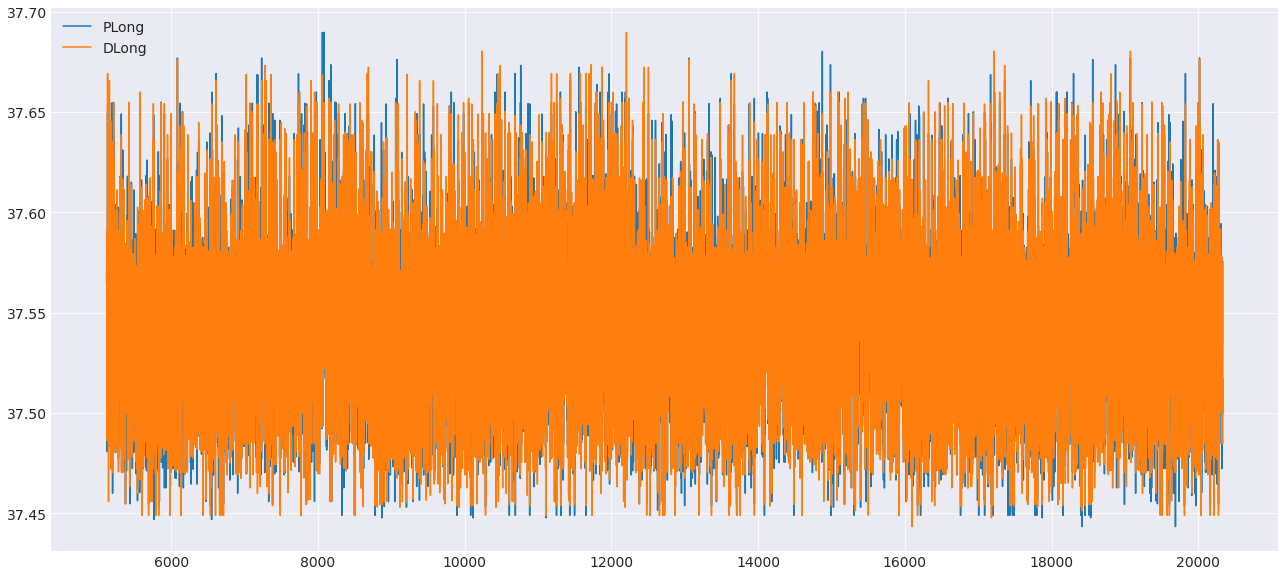

In [33]:
plt.figure(figsize = (22,10))
plt.rc('font', size=14)
plt.plot(seoul_data['PLong'][5000:20000], label = "PLong")
plt.plot(seoul_data['DLong'][5000:20000], label = "DLong")
plt.legend()
plt.show()

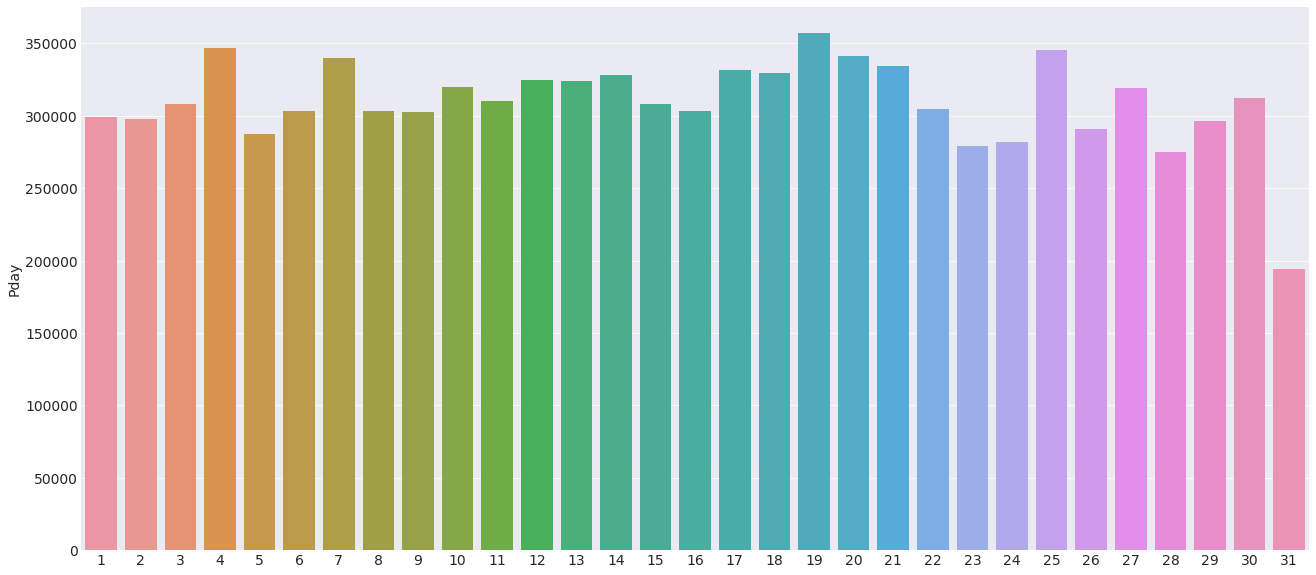

In [34]:
plt.figure(figsize = (22,10))
plt.rc('font', size=14)
sns.barplot( y=seoul_data.Pday.value_counts(), x=seoul_data.Pday.value_counts().index)
plt.show()

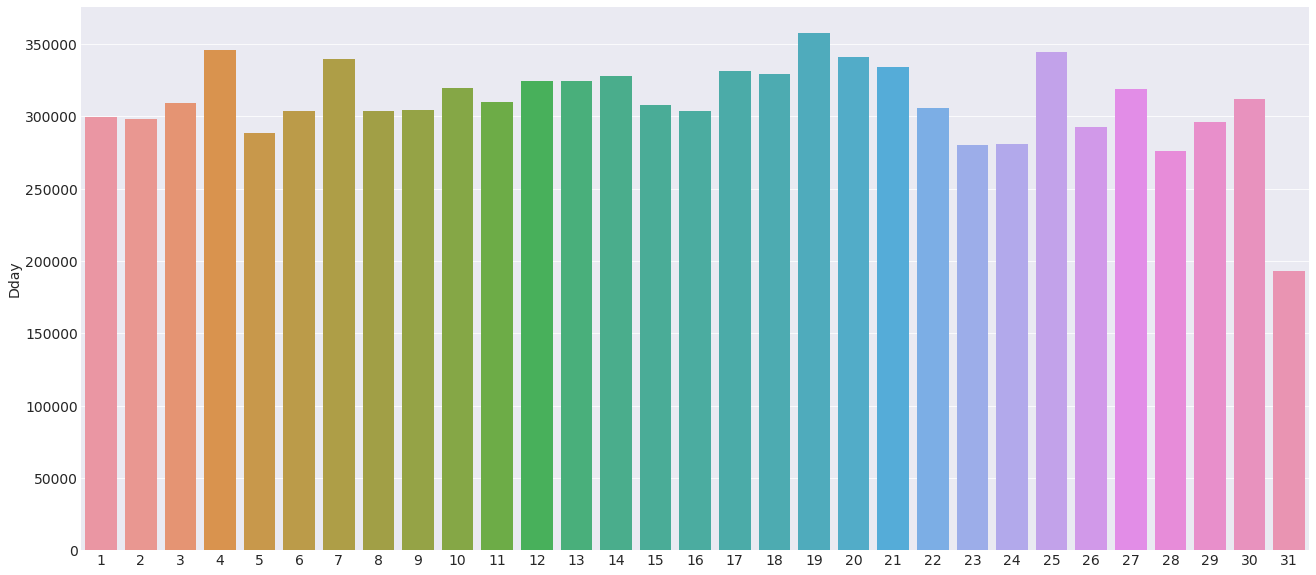

In [35]:
plt.figure(figsize = (22,10))
plt.rc('font', size=14)
sns.barplot( y=seoul_data.Dday.value_counts(), x=seoul_data.Dday.value_counts().index)
plt.show()

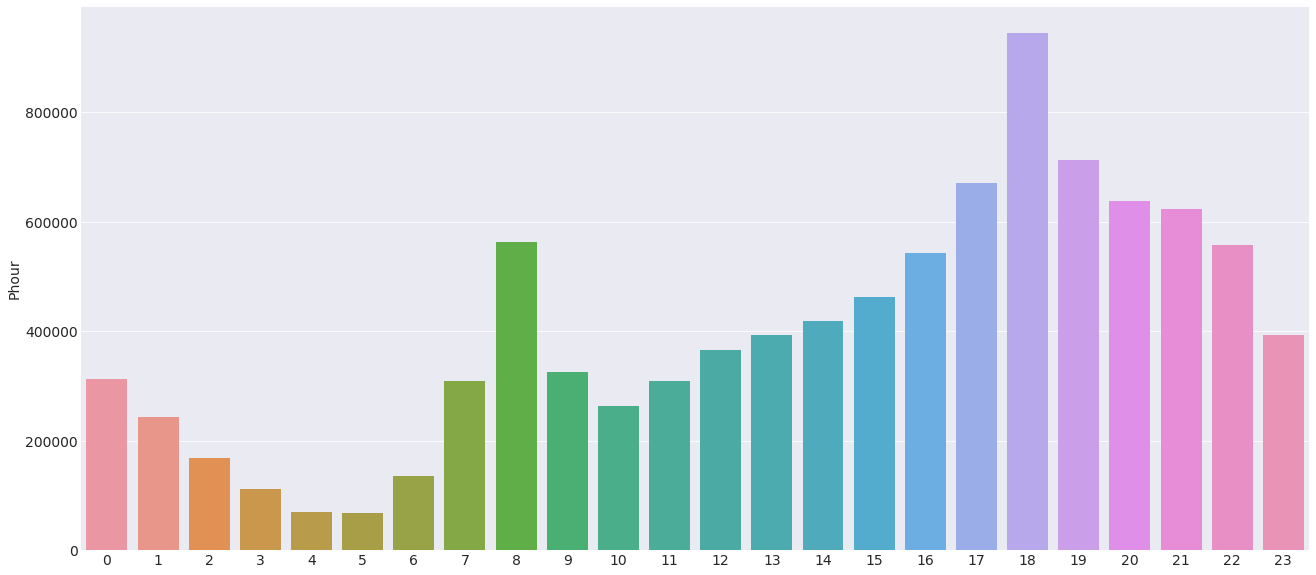

In [36]:
plt.figure(figsize = (22,10))
plt.rc('font', size=14)
sns.barplot( y=seoul_data.Phour.value_counts(), x=seoul_data.Phour.value_counts().index)
plt.show()

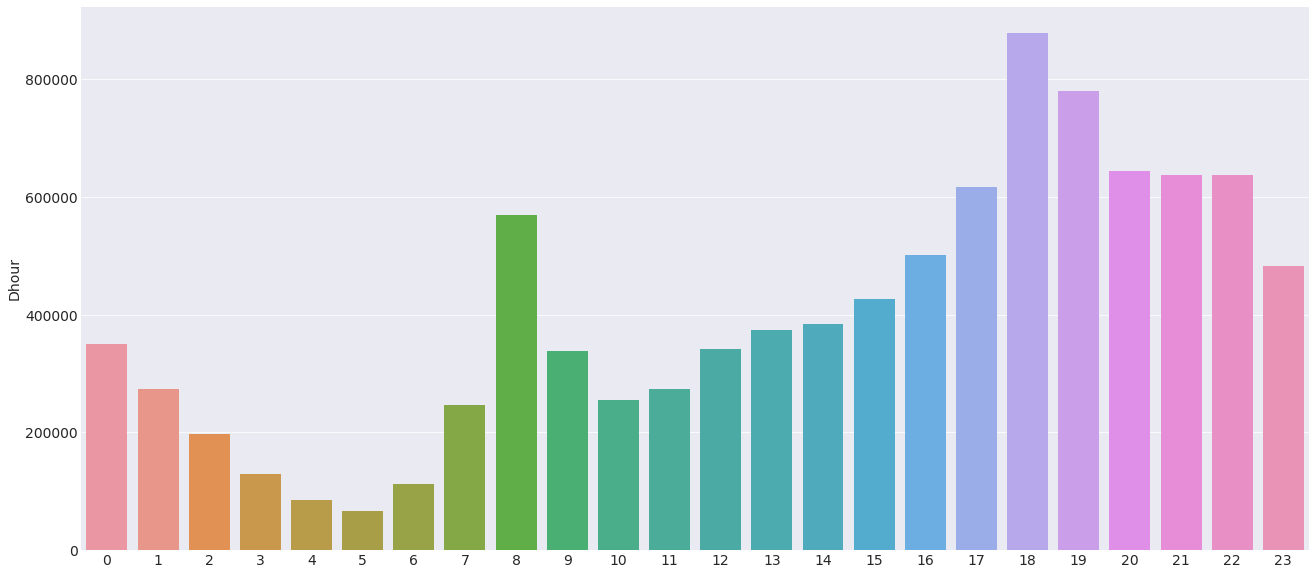

In [37]:
plt.figure(figsize = (22,10))
plt.rc('font', size=14)
sns.barplot( y=seoul_data.Dhour.value_counts(), x=seoul_data.Dhour.value_counts().index)
plt.show()

In [38]:
(seoul_data == 0.00).sum()

Duration            0
Distance            0
PLong               0
PLatd               0
DLong               0
DLatd               0
Haversine      955083
Pmonth              0
Pday                0
Phour          312614
Pmin           151097
PDweek        1368433
Dmonth              0
Dday                0
Dhour          350663
Dmin           157305
DDweek        1367274
Temp             2857
Precip        9485238
Wind            39987
Humid               0
Solar         3439939
Snow          9531693
GroundTemp      53281
Dust           237024
dtype: int64

In [39]:
print(seoul_data["PLatd"][1])
print(seoul_data["PLong"][1])
print(seoul_data["DLatd"][1])
print(seoul_data["DLong"][1])

127.003944
37.506199
127.035103
37.55125


In [40]:
seoul_data.columns

Index(['Duration', 'Distance', 'PLong', 'PLatd', 'DLong', 'DLatd', 'Haversine',
       'Pmonth', 'Pday', 'Phour', 'Pmin', 'PDweek', 'Dmonth', 'Dday', 'Dhour',
       'Dmin', 'DDweek', 'Temp', 'Precip', 'Wind', 'Humid', 'Solar', 'Snow',
       'GroundTemp', 'Dust'],
      dtype='object')

In [41]:
seoul_data[['PLatd','PLong']] = seoul_data[['PLong','PLatd']]
seoul_data[['DLatd','DLong']] = seoul_data[['DLong','DLatd']]

In [42]:
def calc_haversine(lon1, lat1, lon2, lat2, is_deg=True):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians
    if is_deg:
        lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = (sin(dlat/2)**2) + ((cos(lat1) * cos(lat2)) * sin(dlon/2)**2)
    c = 2 * asin(sqrt(a)) 
    # Radius of earth in kilometers is 6371
    km = 6371* c
    return km

d = seoul_data["Haversine"][1]
plat = seoul_data["PLatd"][1]
plon = seoul_data["PLong"][1]
dlat = seoul_data["DLatd"][1]
dlon = seoul_data["DLong"][1]

print(d)
calc_haversine(plon, plat, dlon, dlat)


5.713528999751687


5.713521107899132

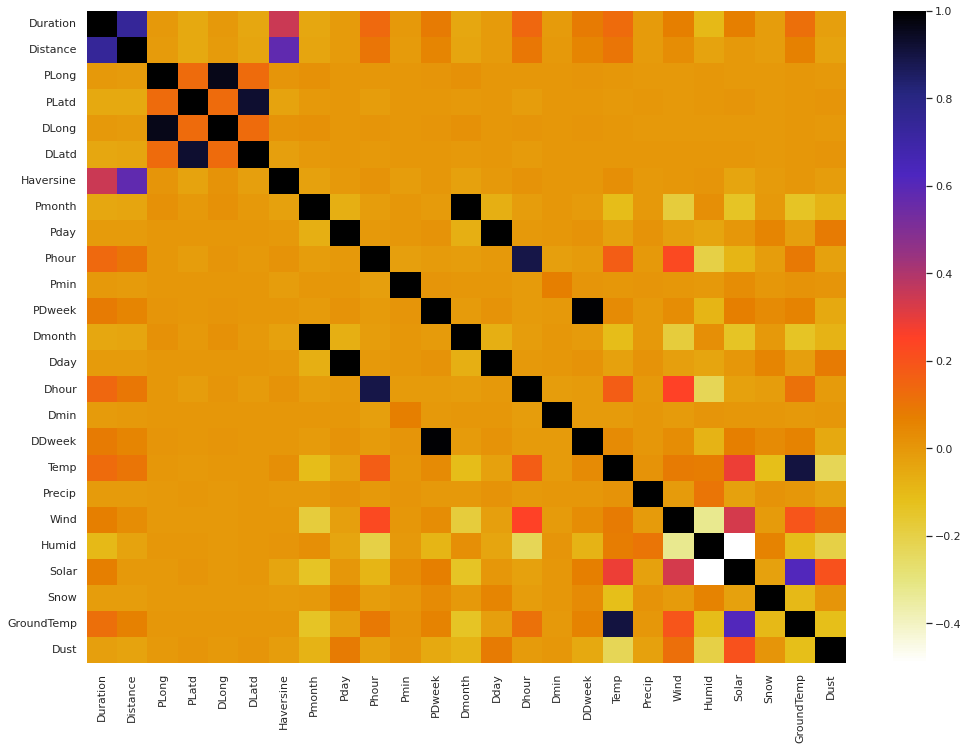

In [43]:
#correlation

sns.set()
plt.figure(figsize=(17,12))
sns.heatmap(seoul_data.corr(), annot=False, cmap=plt.cm.CMRmap_r)
plt.show()

In [44]:
ids = list(np.where(seoul_data["Haversine"] == 0.00)[0])
len(ids)

955083

In [45]:
seoul_data.drop(labels=["Snow", "Precip", "PLatd", "PLong", "DLatd", "DLong"], axis=1, inplace=True)
seoul_data = seoul_data.loc[seoul_data["Dust"] * seoul_data["Wind"] * seoul_data["Haversine"] * seoul_data["Solar"]!= 0.0]
seoul_data.reset_index(drop=True, inplace=True)

seoul_data.drop(labels=["Dday", "Dmonth", "DDweek"], axis=1, inplace=True)

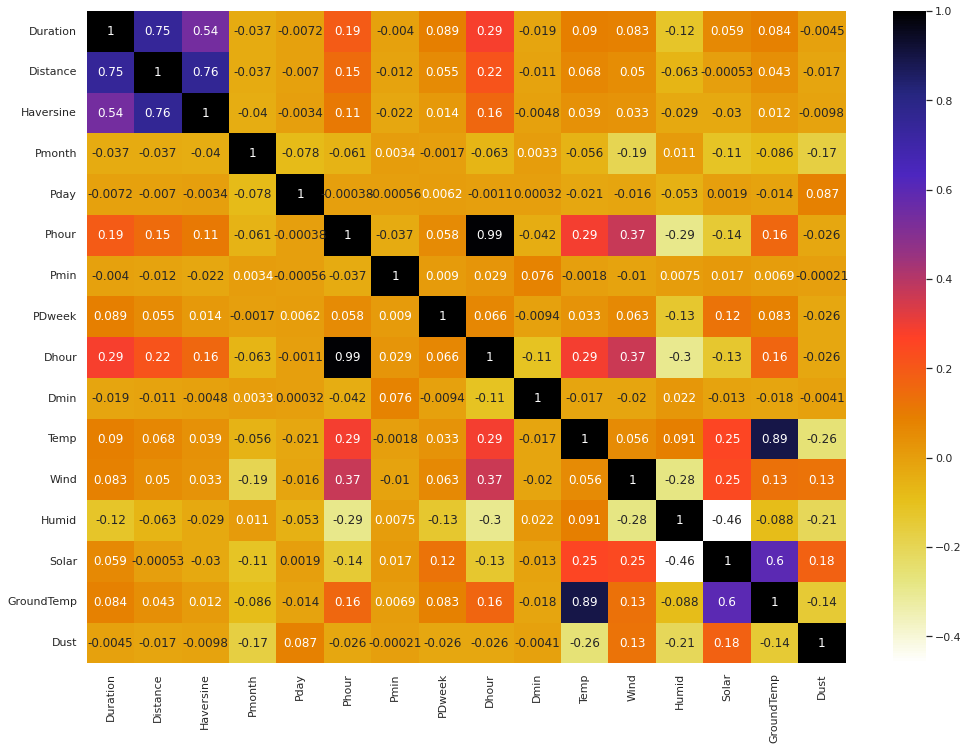

In [46]:
plt.figure(figsize=(17,12))
sns.set()
sns.heatmap(seoul_data.corr(), annot=True, cmap=plt.cm.CMRmap_r)
plt.show()

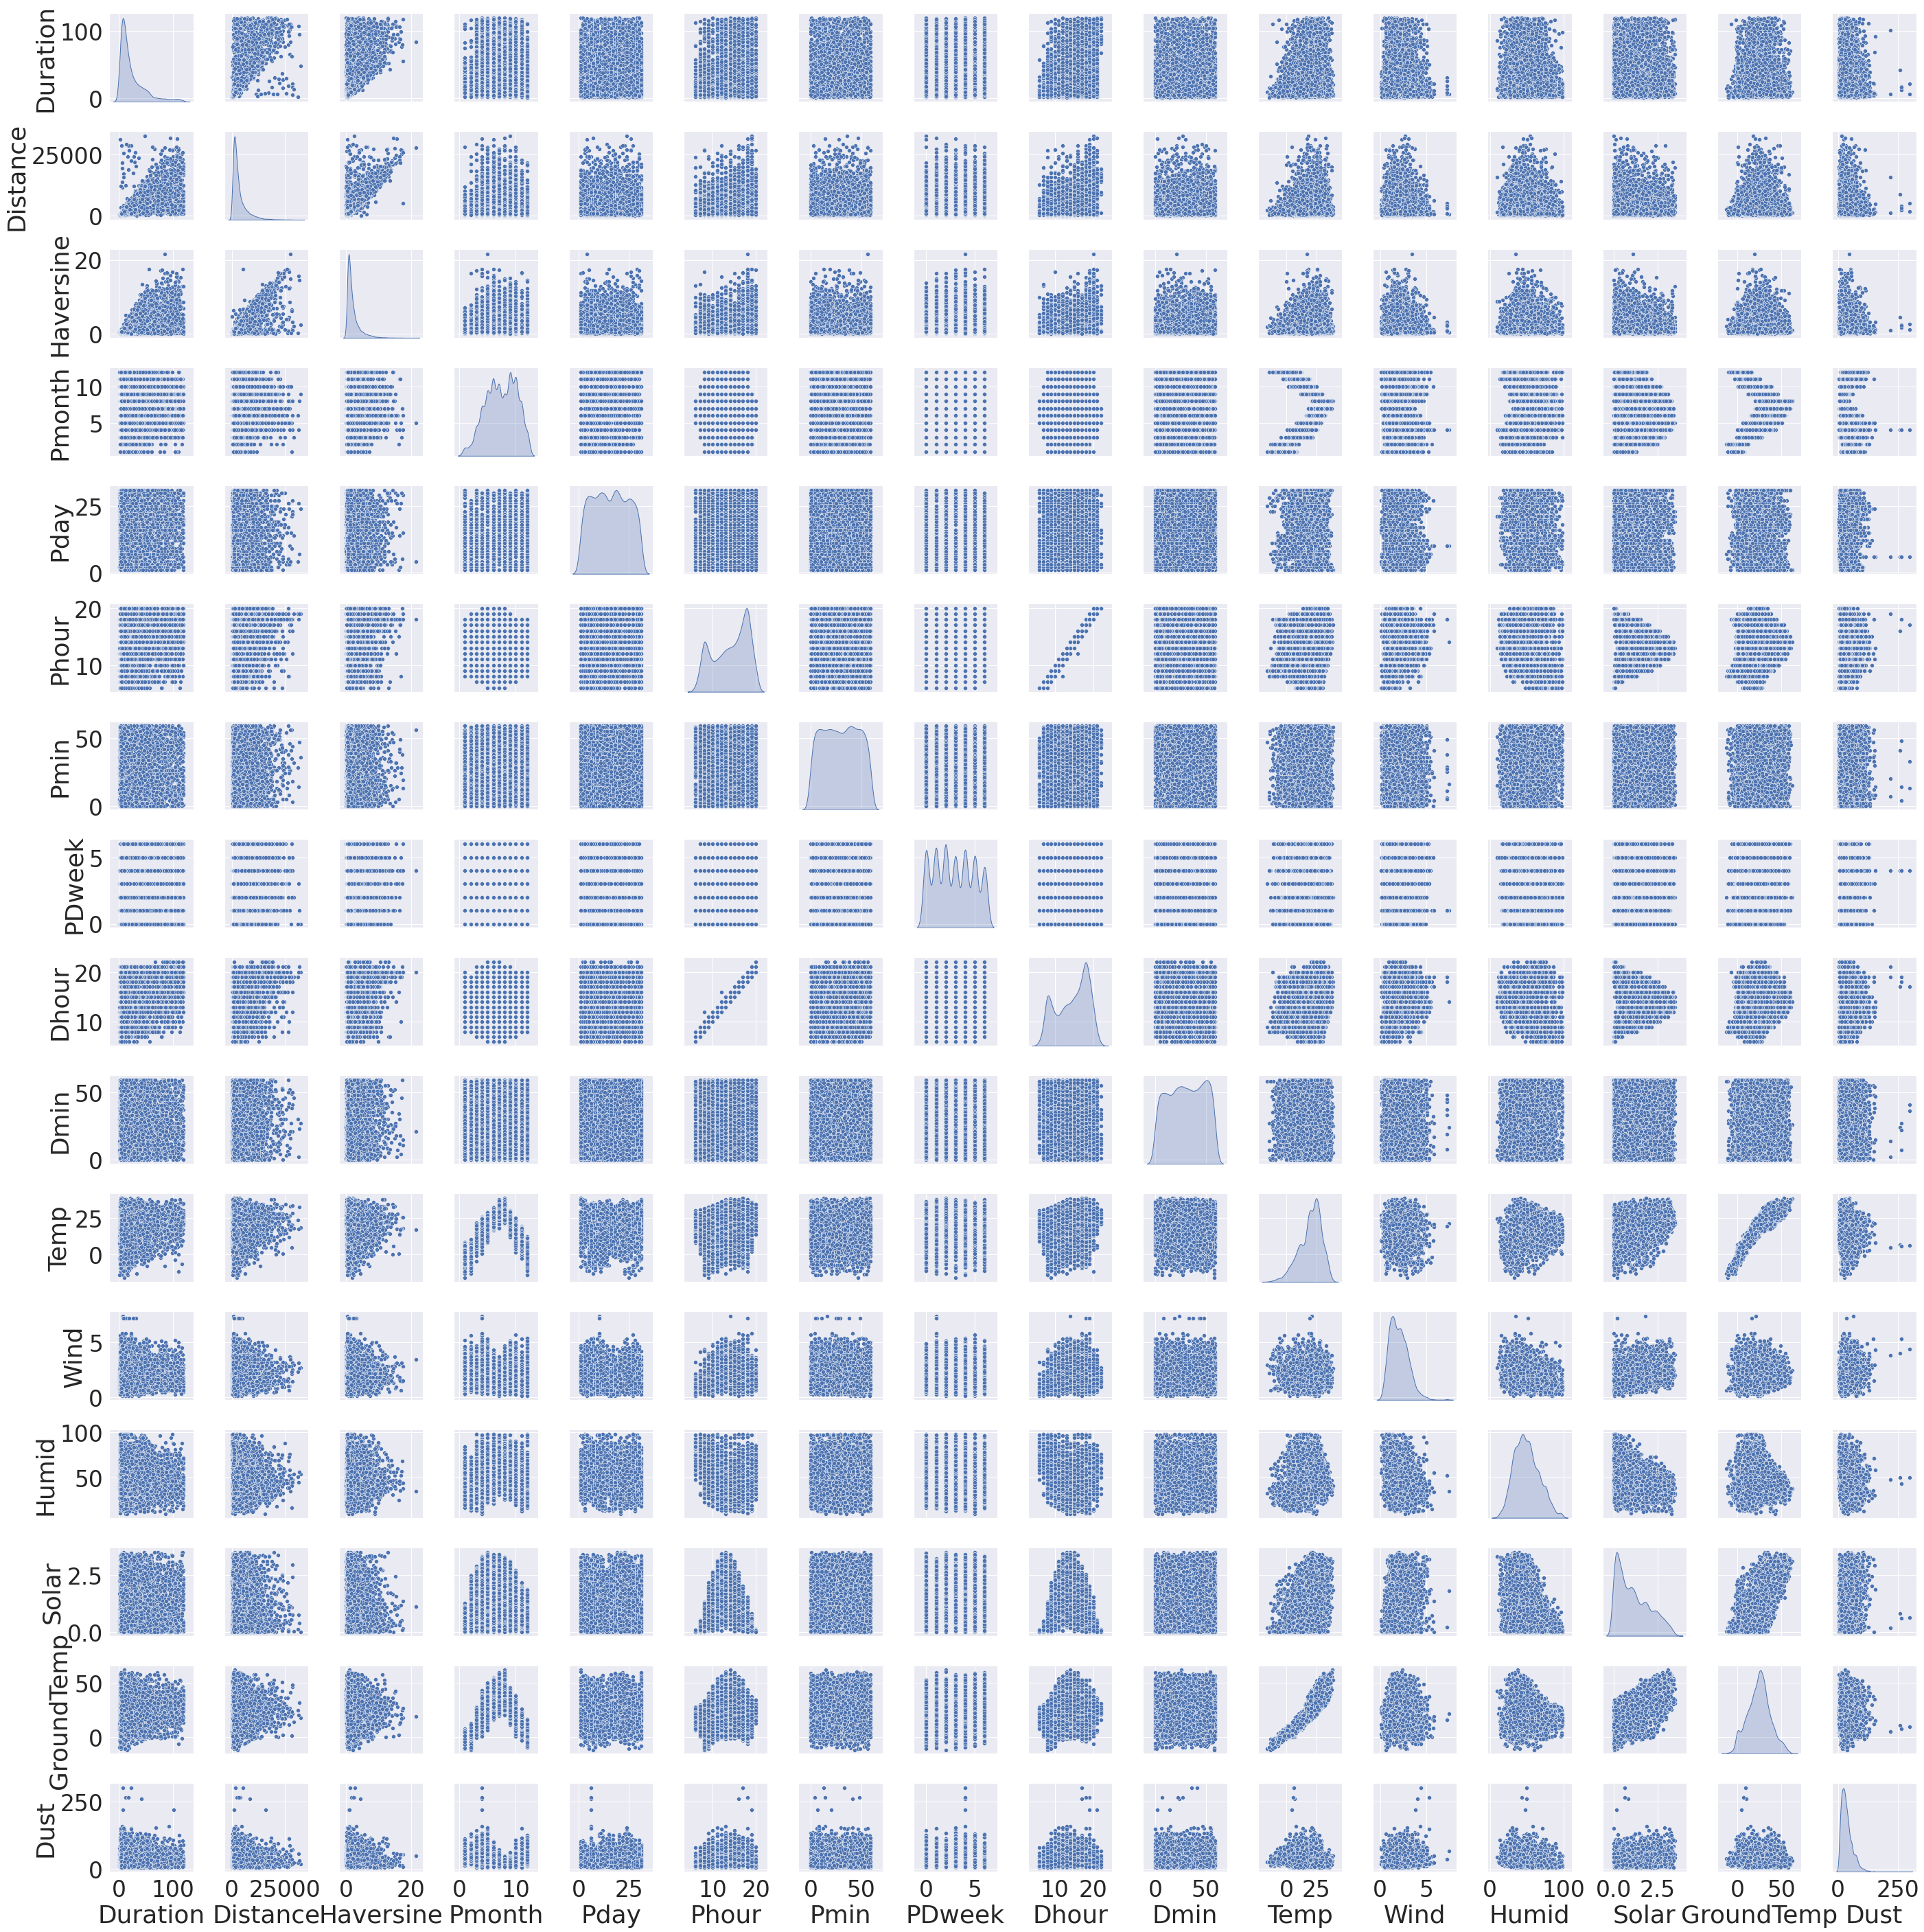

In [47]:
sampling = seoul_data.sample(n=10000)

sns.set(font_scale=3)
sns.pairplot(sampling, diag_kind='kde');

In [48]:
seoul_data_sample = seoul_data.sample(n=53609, replace=True,random_state=101)
seoul_data_sample.reset_index(drop=True,inplace=True)

In [49]:
X = seoul_data_sample.drop(labels=["Duration"], axis = 1)
y = seoul_data_sample["Duration"]

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=101)

In [51]:
rfe = RFE(estimator=RandomForestRegressor(), n_features_to_select=10)
X_train_rfe = rfe.fit_transform(X_train,y_train)
X_test_rfe = rfe.transform(X_test)

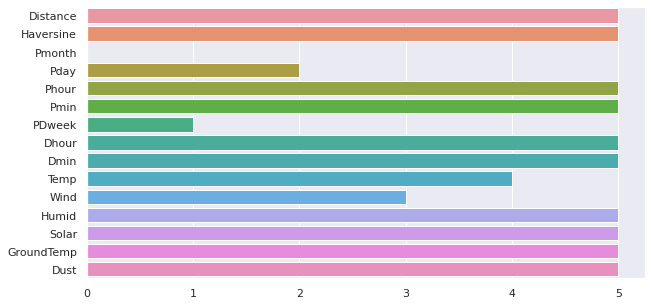

In [52]:
sns.set()
plt.figure(figsize=(10,5))
sns.barplot(y = X_train.columns, x = max(rfe.ranking_) - rfe.ranking_);

In [53]:
feature_list_rfe = [col for i,col in enumerate(X_train.columns) if rfe.support_[i]]
feature_list_rfe

['Distance',
 'Haversine',
 'Phour',
 'Pmin',
 'Dhour',
 'Dmin',
 'Humid',
 'Solar',
 'GroundTemp',
 'Dust']

In [54]:
from xgboost import XGBRegressor
xgb = XGBRegressor()
xgb.fit(X_train_rfe, y_train)
y_hat_test = xgb.predict(X_test_rfe)

In [55]:
print(f'Training score : {xgb.score(X_train_rfe, y_train)}')

print()
print('r2 score:', r2_score(y_test, y_hat_test))
print('MAE:', mean_absolute_error(y_test, y_hat_test))
print('MSE:', mean_squared_error(y_test, y_hat_test))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_hat_test)))

Training score : 0.9782603414253052

r2 score: 0.9366865226354358
MAE: 3.050012411555385
MSE: 34.731537297163655
RMSE: 5.893346867202341


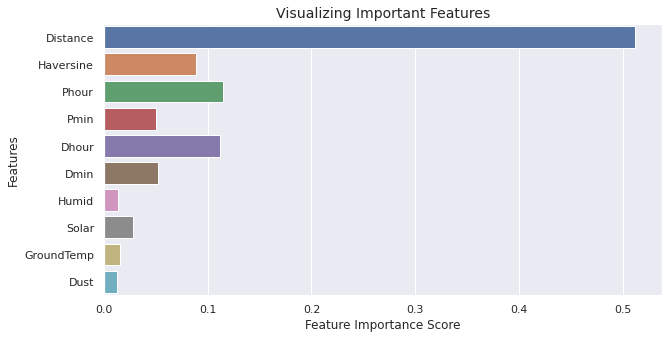

In [56]:
plt.figure(figsize=(10,5))
sns.barplot(x = xgb.feature_importances_, y = feature_list_rfe)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features", size=14);

In [57]:
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint 

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [58]:
params = {'bootstrap': [True, False],
 'max_depth': [10, 50, 100,None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 1000, 2000]}

In [59]:
# Use the random grid to search for best hyperparameters
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = xgb, param_distributions = params, n_iter = 1, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train_rfe, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  9.1min finished


[02:01:36] WARNING: ../src/learner.cc:573: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          gpu_id=-1, importance_type='gain',
                                          interaction_constraints='',
                                          learning_rate=0.300000012,
                                          max_delta_step=0, max_depth=6,
                                          min_child_weight=1, missing=nan,
                                          monotone_constraints='()',
                                          n_estimators=100, n_jobs=4,
                                          num_par...
                                          reg_alpha=0, reg_lambda=1,
                                          scale_pos_weight=1, subsample=1,
   

In [60]:
rf_random.best_params_

{'n_estimators': 200,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 50,
 'bootstrap': True}

In [61]:
best_params = {'n_estimators': 200,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 50,
 'bootstrap': True}

xgb = xgb = XGBRegressor(**best_params)
xgb.fit(X_train_rfe, y_train)
y_hat_test = xgb.predict(X_test_rfe)

[02:01:52] WARNING: ../src/learner.cc:573: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [62]:
print(f'Training score : {xgb.score(X_train_rfe, y_train)}')

print()
print('r2 score:', r2_score(y_test, y_hat_test))
print('MAE:', mean_absolute_error(y_test, y_hat_test))
print('MSE:', mean_squared_error(y_test, y_hat_test))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_hat_test)))

Training score : 0.9999999996535791

r2 score: 0.7578217012218222
MAE: 5.937644107176512
MSE: 132.85046038690007
RMSE: 11.526077406772005


In [63]:
 import joblib

In [64]:
joblib.dump(xgb, "final_model_best.joblib")

['final_model_best.joblib']